In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns


az.style.use('arviz-darkgrid')

In [2]:
WAFFLE_DATA = 'waffle_divorce.csv'
DATA_FOLDER = '../../data'

In [3]:
df_waf = pd.read_csv(f'{DATA_FOLDER}/{WAFFLE_DATA}')
df_waf.head()

,Unnamed: 0,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage.SE,Divorce,Divorce.SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,4,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


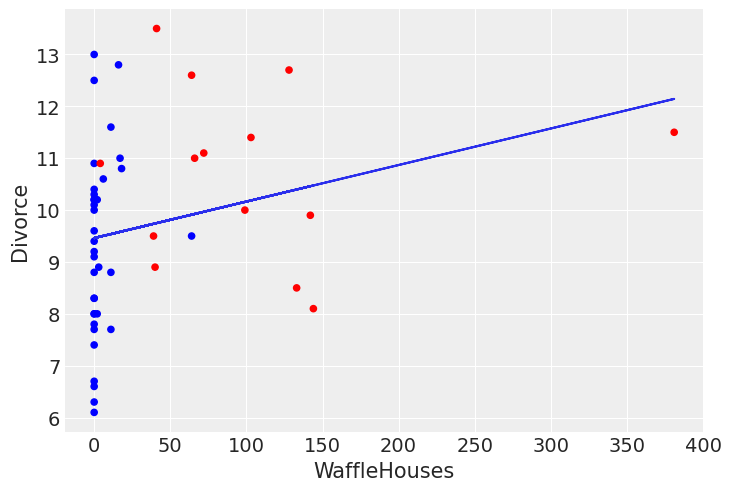

In [4]:
x = df_waf['WaffleHouses']
y = df_waf['Divorce']

colors = df_waf['South'].apply(lambda x: 'r' if x == 1 else 'b')

# Fit the data to a line using polyfit
m, c = np.polyfit(x, y, 1)

# Plot both the line and the original data
_, ax = plt.subplots(1, 1)
ax.plot(x, m * x + c)

df_waf.plot.scatter(x='WaffleHouses', y='Divorce', marker='o', c=colors, ax=ax)

plt.show()

### Code 5.1 Standardize Variables

In [5]:
age = (df_waf['MedianAgeMarriage'] - df_waf['MedianAgeMarriage'].mean()) / df_waf['MedianAgeMarriage'].std()
divorce = (df_waf['Divorce'] - df_waf['Divorce'].mean()) / df_waf['Divorce'].std()
marriage = (df_waf['Marriage'] - df_waf['Marriage'].mean()) /df_waf['Marriage'].std()

## The Model: Divorce Rate vs Median Age

$$
\begin{align*}
    D_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & \sim \alpha + \beta_A \cdot A_i \\
    \alpha  & \sim N(0, 0.2) \\
    \beta_A & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

In [6]:
np.std(df_waf['Divorce']), np.std(df_waf['MedianAgeMarriage'])

(1.8025138002245642, 1.231131187160816)

### The Priors

Since both $D_i$ and $A_i$ are standardized, we would expect $\alpha \approx 0$. Thus we may use an even smaller standard deviation value than $0.2$ for the prior of $\alpha$. If $\beta_A = 1$, then a one standard deviation change at the median age of marriage results in a change of one standard deviation in the divorce rate. The prior $\beta_A \sim N(0, 0.5)$ places only $5\%$ probability of that happening.    

### Code 5.3

In [7]:
with pm.Model() as m_5_1:
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    beta_A = pm.Normal('beta_A', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_A * age)
    D = pm.Normal('divorce', mu=mu, sigma=sigma, observed=divorce)
    
    trace_5_1 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_A, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 9 seconds.


/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


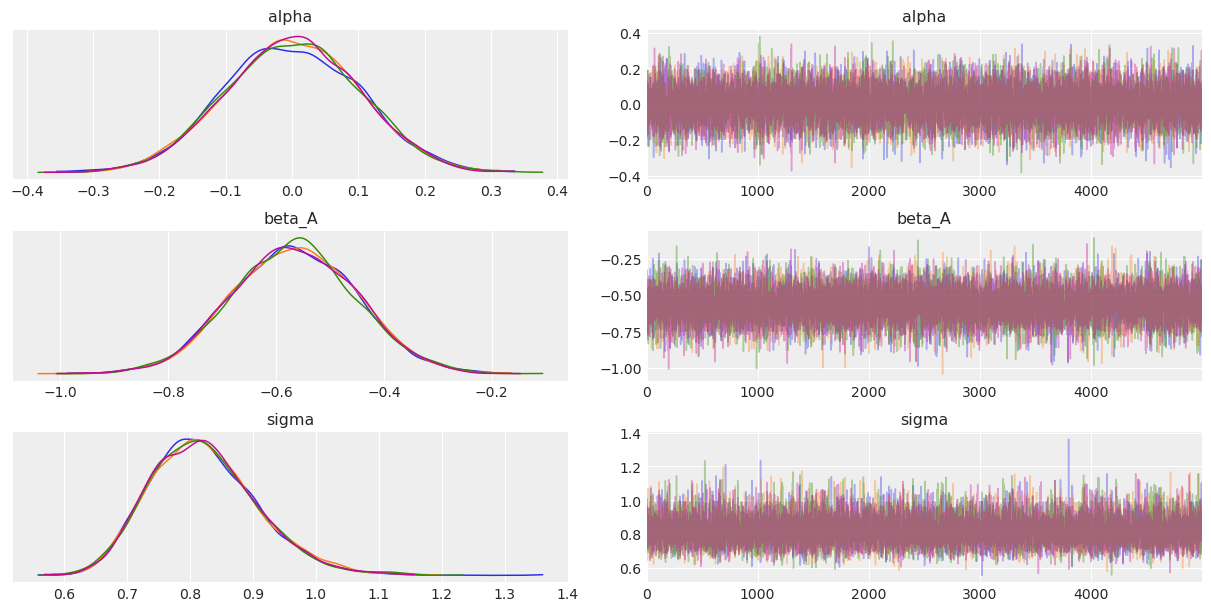

In [8]:
az.plot_trace(trace_5_1, var_names=['alpha', 'beta_A', 'sigma'])

plt.show()

In [9]:
df_tr_5_1 = pm.trace_to_dataframe(trace_5_1)
df_tr_5_1.head()

,alpha,beta_A,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,0.055465,-0.500287,0.710690,0.358784,0.399012,0.157644,0.761063,-0.244635,0.197872,-0.566459,...,0.238100,0.399012,0.399012,1.163342,-0.284863,-0.083724,0.117416,0.479467,-0.043496,0.801291
1,-0.058374,-0.628109,0.839389,0.322442,0.372948,0.069912,0.827503,-0.435149,0.120418,-0.839198,...,0.170924,0.372948,0.372948,1.332564,-0.485655,-0.233125,0.019405,0.473960,-0.182619,0.878009
2,-0.017932,-0.466281,0.764254,0.264769,0.302263,0.077302,0.639705,-0.297633,0.114795,-0.597581,...,0.152289,0.302263,0.302263,1.014640,-0.335127,-0.147659,0.039808,0.377250,-0.110166,0.677198
3,0.042943,-0.647481,0.882120,0.435504,0.487567,0.175185,0.956141,-0.345453,0.227249,-0.761963,...,0.279312,0.487567,0.487567,1.476779,-0.397516,-0.137198,0.123121,0.591695,-0.085134,1.008205
4,-0.117397,-0.451021,0.798258,0.156052,0.192318,-0.025280,0.518717,-0.387945,0.010986,-0.678076,...,0.047253,0.192318,0.192318,0.881381,-0.424211,-0.242879,-0.061547,0.264851,-0.206612,0.554983


In [10]:
df_mu_5_1 = df_tr_5_1.filter(regex=('mu.*'))
mu_mean = df_mu_5_1.apply(np.mean, axis=0)

In [11]:
mu_mean.values.shape

(50,)

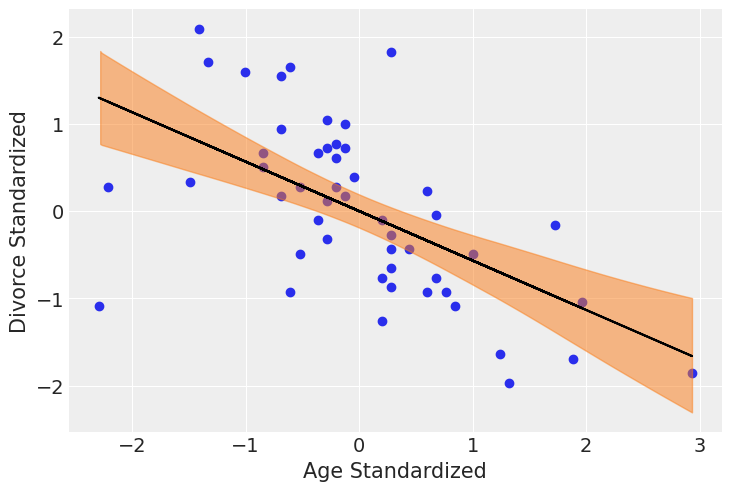

In [12]:
_, ax = plt.subplots(1, 1)
ax.scatter(age, divorce, marker='o')

ax.plot(age, mu_mean, 'k')

az.plot_hdi(age, np.expand_dims(df_mu_5_1.values, 0), ax=ax)

ax.set_xlabel('Age Standardized')
ax.set_ylabel('Divorce Standardized')

plt.show()

## Prior Predictive Plots

### Code 5.4

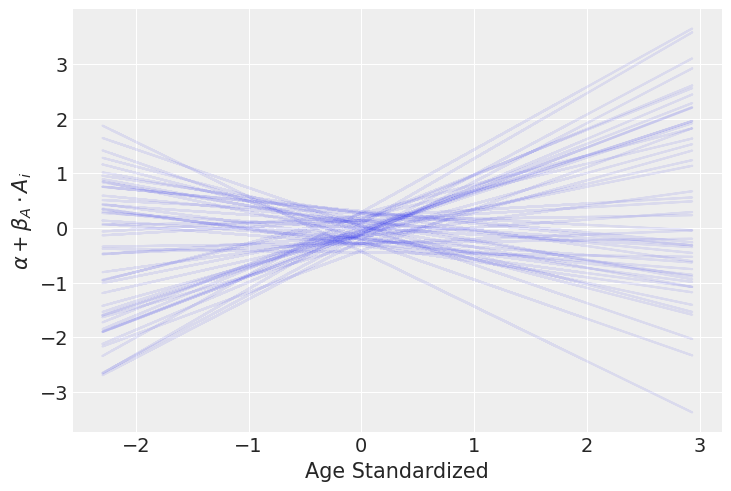

In [13]:
from scipy.stats import norm


N = 50 
alpha_vals = norm.rvs(loc=0, scale=0.2, size=N)
beta_vals = norm.rvs(loc=0, scale=0.5, size=N)

_, ax = plt.subplots(1, 1)
ax.set_xlabel('Age Standardized')
ax.set_ylabel(r'$\alpha + \beta_A \cdot A_i$')

for i in range(N):
    alpha_i = alpha_vals[i]
    beta_i = beta_vals[i]
    
    mu_values = [alpha_i + beta_i * a for a in age]
    
    ax.plot(age, mu_values, color='C0', alpha=0.1)

plt.show()

## Posterior Plots

Since PyMC3 already includes the posterior samples in the trace, we really don't have to do anything more.

### Code 5.5

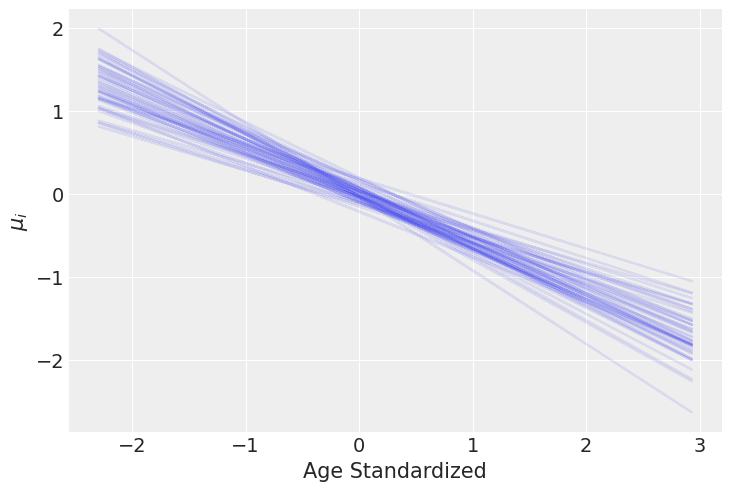

In [14]:
df_mu_T = df_mu_5_1.T

sample = np.random.choice(range(0, 20000), size=50)

_, ax = plt.subplots(1, 1)
ax.plot(age, df_mu_T.loc[:, sample], color='C0', alpha=0.1)

ax.set_xlabel('Age Standardized')
ax.set_ylabel(r'$\mu_i$')

plt.show()

## The Model: Divorce Rate vs Marriage Rate

$$
\begin{align*}
    D_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & \sim \alpha + \beta_M \cdot M_i \\
    \alpha  & \sim N(0, 0.2) \\
    \beta_M & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

### Code 5.6

In [15]:
with pm.Model() as m_5_2:
    alpha = pm.Normal('alpha', mu=0.0, sigma=0.2)
    beta_M = pm.Normal('beta_M', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_M * marriage)
    D_2 = pm.Normal('divorce', mu=mu, sigma=sigma, observed=divorce)
    
    trace_5_2 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 11 seconds.


/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


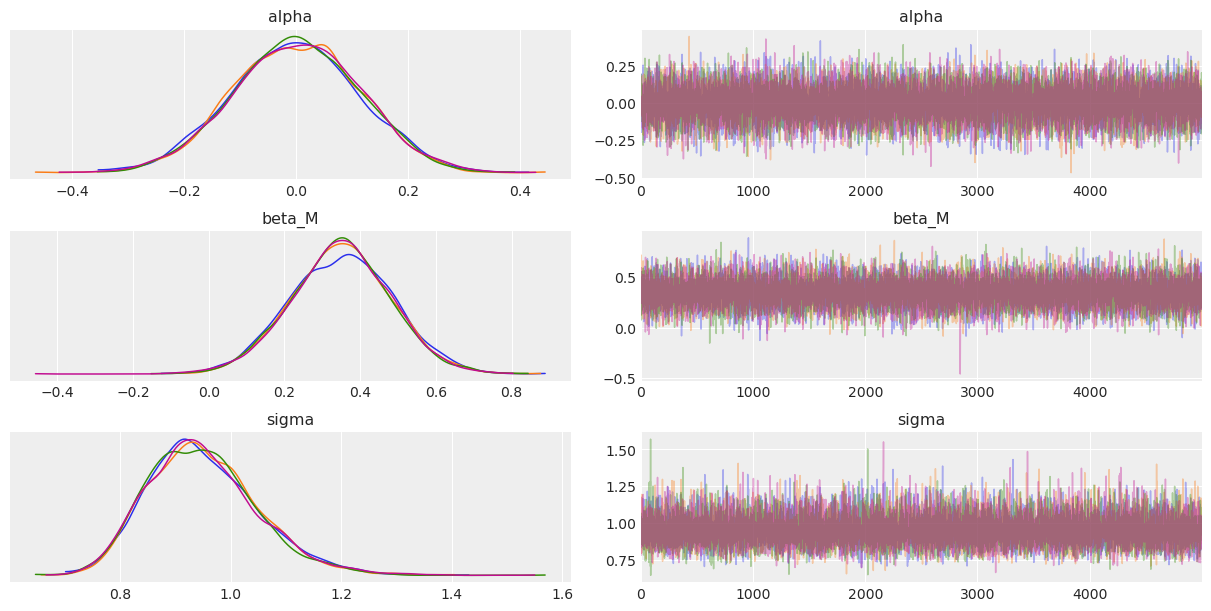

In [16]:
az.plot_trace(trace_5_2, var_names=['alpha', 'beta_M', 'sigma'])

plt.show()

In [17]:
df_tr_5_2 = pm.trace_to_dataframe(trace_5_2)
df_mu_2 = df_tr_5_2.filter(regex='(mu.*)')

df_mu_2.head()

,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,-0.169257,0.188564,-0.163087,0.213242,-0.237119,0.034331,-0.360506,0.009654,-0.323490,-0.366675,...,-0.175426,-0.218611,-0.089055,0.410660,-0.403691,-0.150749,-0.095225,-0.045870,-0.354336,0.478523
1,-0.118400,0.306771,-0.111069,0.336093,-0.199036,0.123508,-0.345646,0.094186,-0.301663,-0.352977,...,-0.125730,-0.177044,-0.023103,0.570670,-0.396960,-0.096408,-0.030433,0.028211,-0.338316,0.651306
2,0.076731,0.740049,0.088167,0.785795,-0.049071,0.454136,-0.277801,0.408390,-0.209182,-0.289238,...,0.065294,-0.014761,0.225406,1.151764,-0.357857,0.111040,0.213969,0.305461,-0.266365,1.277565
3,-0.012535,0.185980,-0.009112,0.199670,-0.050184,0.100413,-0.118637,0.086723,-0.098101,-0.122060,...,-0.015957,-0.039916,0.031960,0.309195,-0.142596,-0.002267,0.028537,0.055919,-0.115214,0.346844
4,-0.190156,0.184692,-0.183693,0.210543,-0.261248,0.023119,-0.390506,-0.002732,-0.351729,-0.396969,...,-0.196619,-0.241860,-0.106139,0.417356,-0.435746,-0.170768,-0.112602,-0.060898,-0.384043,0.488448


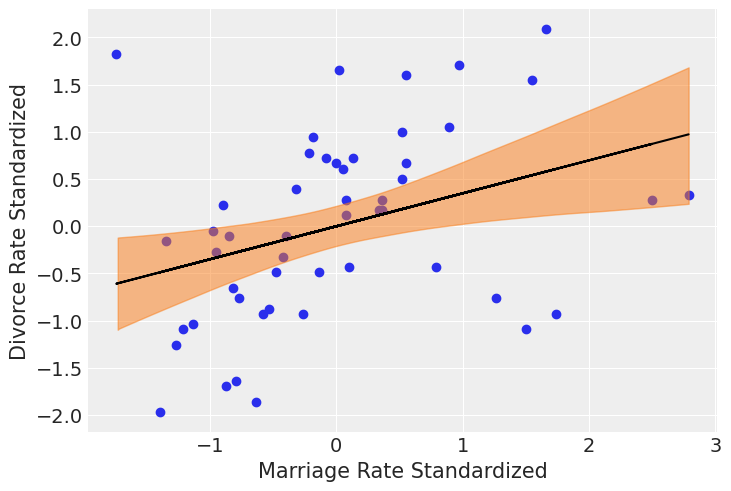

In [18]:
mu_mean_2 = df_mu_2.apply(np.mean, axis=0)

_, ax = plt.subplots(1, 1)
ax.scatter(marriage, divorce, marker='o')

ax.plot(marriage, mu_mean_2, 'k')

az.plot_hdi(marriage, np.expand_dims(df_mu_2.values, 0), ax=ax)

ax.set_xlabel('Marriage Rate Standardized')
ax.set_ylabel('Divorce Rate Standardized')

plt.show()

## Causal Graphs

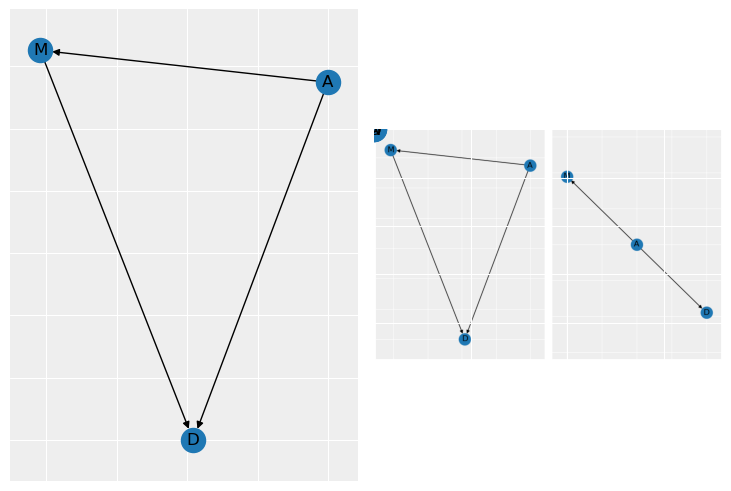

In [19]:
import networkx as nx
import matplotlib.image as mpimg


_, (ax1, ax2) = plt.subplots(1, 2)
g1 = nx.DiGraph()
g2 = nx.DiGraph()

g1.add_edges_from([('A', 'M'), ('A', 'D'), ('M', 'D')])
g2.add_edges_from([('A', 'M'), ('A', 'D')])

#plt.tight_layout()

nx.draw_networkx(g1, arrows=True, ax=ax1)
nx.draw_networkx(g2, arrows=True, ax=ax2)

plt.savefig('DAG1.png', format='PNG')

img = mpimg.imread('DAG1.png')
plt.imshow(img)

## Conditional Independence

In [20]:
df_waf['age_stan'] = (df_waf['MedianAgeMarriage'] - df_waf['MedianAgeMarriage'].mean()) / df_waf['MedianAgeMarriage'].std()
df_waf['divorce_stan'] = (df_waf['Divorce'] - df_waf['Divorce'].mean()) / df_waf['Divorce'].std()
df_waf['marriage_stan'] = (df_waf['Marriage'] - df_waf['Marriage'].mean()) /df_waf['Marriage'].std()

In [21]:
df_waf[['age_stan', 'marriage_stan', 'divorce_stan']].cov()

,age_stan,marriage_stan,divorce_stan
age_stan,1.000000,-0.721096,-0.597239
marriage_stan,-0.721096,1.000000,0.373731
divorce_stan,-0.597239,0.373731,1.000000


<AxesSubplot:xlabel='marriage_stan', ylabel='divorce_stan'>

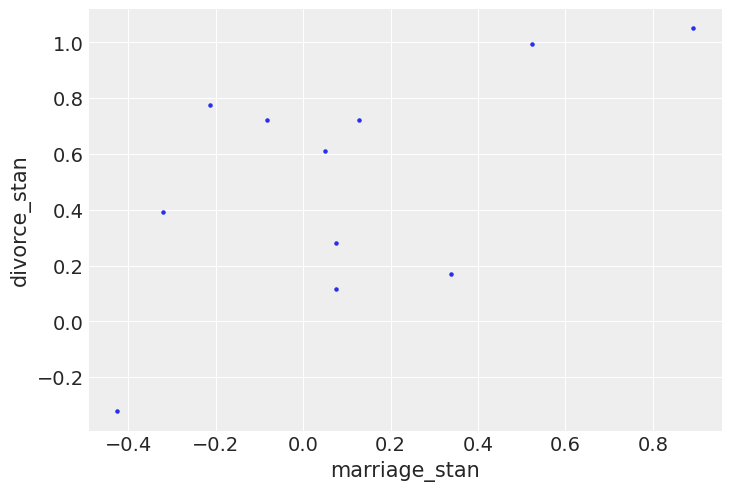

In [22]:
df_waf[(df_waf['age_stan'] >= -0.3) & 
       (df_waf['age_stan'] <= 0.0)][['marriage_stan', 
                                     'divorce_stan']].plot.scatter(x='marriage_stan', 
                                                                   y='divorce_stan', 
                                                                   marker='.')

## Multiple Regression Model

$$
\begin{align*}
    D_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & \sim \alpha + \beta_A \cdot A_i + \beta_M \cdot M_i\\
    \alpha  & \sim N(0, 0.2) \\
    \beta_A & \sim N(0, 0.5) \\
    \beta_M & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

### Code 5.10

In [23]:
with pm.Model() as m_5_3:
    alpha = pm.Normal('alpha', mu=0.0, sigma=0.2)
    beta_A = pm.Normal('beta_A', mu=0.0, sigma=0.5)
    beta_M = pm.Normal('beta_M', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1.0)
    
    mu = pm.Deterministic('mu', alpha + beta_A * df_waf['age_stan'] + beta_M * df_waf['marriage_stan'])
    D = pm.Normal('divorce', mu=mu, sigma=sigma, observed=df_waf['divorce_stan'])
    
    trace_5_3 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, beta_A, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 11 seconds.


In [24]:
az.summary(trace_5_3, var_names=['alpha', 'beta_A', 'beta_M', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.100,-0.154,0.165,0.001,0.001,16023.0,9810.0,16050.0,13482.0,1.0
beta_A,-0.607,0.159,-0.867,-0.360,0.001,0.001,11340.0,11340.0,11345.0,12839.0,1.0
beta_M,-0.060,0.160,-0.316,0.193,0.001,0.001,11729.0,11170.0,11733.0,13411.0,1.0
sigma,0.827,0.089,0.687,0.961,0.001,0.001,15359.0,15137.0,15469.0,11324.0,1.0


In [25]:
df_tr_5_3 = pm.trace_to_dataframe(trace_5_3)
df_tr_5_3.head()

,alpha,beta_A,beta_M,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,-0.194958,-0.407119,0.018822,0.782370,0.052300,0.113780,-0.110886,0.410389,-0.444196,-0.062291,...,-0.046405,0.081071,0.091479,0.753611,-0.490314,-0.306313,-0.138171,0.160420,-0.289931,0.464436
1,0.197057,-0.740800,-0.062551,0.813820,0.644779,0.608821,0.345295,1.138341,-0.230617,0.352158,...,0.467724,0.717523,0.682936,1.681312,-0.245715,-0.015404,0.267610,0.790542,0.098514,1.127087
2,-0.157222,-0.495466,0.191789,0.774132,0.147517,0.480249,-0.046635,0.859012,-0.505637,0.154801,...,0.022946,0.146958,0.253005,1.419011,-0.681824,-0.275578,-0.030927,0.368035,-0.402383,1.115996
3,-0.092281,-0.424718,-0.030797,0.951705,0.164524,0.151645,-0.007044,0.455764,-0.338828,0.001159,...,0.062881,0.205163,0.188134,0.771331,-0.351086,-0.213575,-0.050115,0.250761,-0.152664,0.455048
4,-0.144379,-0.713641,-0.183520,0.933034,0.284139,0.061258,-0.007612,0.558383,-0.523463,-0.104857,...,0.116820,0.380180,0.278704,0.977591,-0.450379,-0.361578,-0.118149,0.359647,-0.144734,0.407984


## Comparison of the $\beta_M$ and $\beta_A$ values from three models

In [26]:
summary_1 = az.summary(trace_5_1, var_names=['alpha', 'beta_A', 'sigma'], hdi_prob=0.89)
summary_2 = az.summary(trace_5_2, var_names=['alpha', 'beta_M', 'sigma'], hdi_prob=0.89)
summary_3 = az.summary(trace_5_3, var_names=['alpha', 'beta_A', 'beta_M', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less 

In [27]:
type(summary_1)

pandas.core.frame.DataFrame

In [28]:
summary_1.loc['beta_A', :]

mean            -0.567
sd               0.116
hdi_5.5%        -0.748
hdi_94.5%       -0.381
mcse_mean        0.001
mcse_sd          0.001
ess_mean     24861.000
ess_sd       24489.000
ess_bulk     24877.000
ess_tail     14810.000
r_hat            1.000
Name: beta_A, dtype: float64

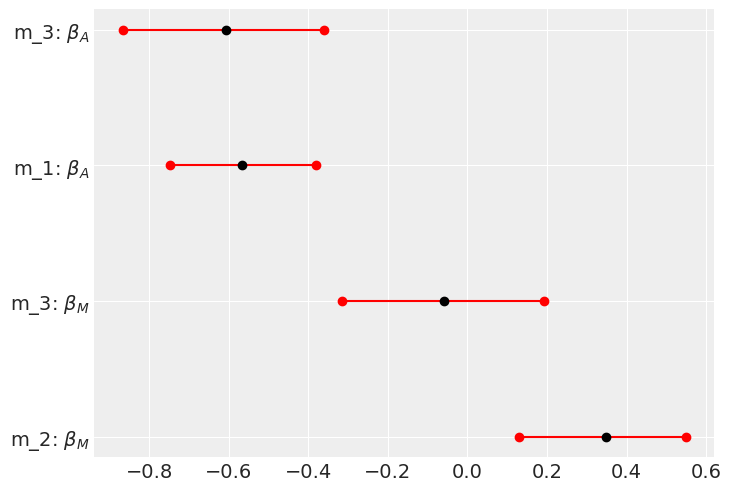

In [29]:
# Do the plots manually!

summary_list = [(summary_2, 'beta_M', 1), 
                (summary_3, 'beta_M', 2), 
                (summary_1, 'beta_A', 3),  
                (summary_3, 'beta_A', 4)]

_, ax = plt.subplots(1, 1)


for summary, var, y_level in summary_list:
    lower = summary.loc[var, 'hdi_5.5%']
    upper = summary.loc[var, 'hdi_94.5%']
    mid = summary.loc[var, 'mean']

    ax.plot((lower, upper), (y_level, y_level), 'ro-')
    ax.plot((mid), (y_level), 'ko')

plt.yticks([1, 2, 3, 4], [r'm_2: $\beta_M$', r'm_3: $\beta_M$', r'm_1: $\beta_A$', r'm_3: $\beta_A$'])

plt.show()